# Fractional Brownian motion & Hurst Exponent

In [50]:
import warnings; warnings.simplefilter('ignore') 
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib 
matplotlib.style.use('ggplot')
%matplotlib inline

import pandas_datareader.data as web
from scipy.stats import norm
from pandas_datareader import data, wb
import pandas_datareader

## Main idea

![title](Fractional_Brownian_Motion.png)

In [51]:
url ='https://realized.oxford-man.ox.ac.uk/images/oxfordmanrealizedvolatilityindices-0.2-final.zip'
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO
from io import StringIO
myzip = urlopen(url) 
z=ZipFile(BytesIO(myzip.read())) 
files_list=z.namelist() 
filename=files_list[0] 
print(filename) 
z.getinfo(filename)
file_data =z.open(filename)
df = pd.read_csv(file_data, index_col=0, header=2 )

OxfordManRealizedVolatilityIndices.csv


In [52]:
rv1 = pd.DataFrame(index=df.index) 
for col in df.columns:
    if col[-3:] == '.rk': 
        rv1[col] = df[col]
rv1.index = [dt.datetime.strptime(str(date), "%Y%m%d") for date in rv1.index.values]

### Test with Dow Jones Industry Average

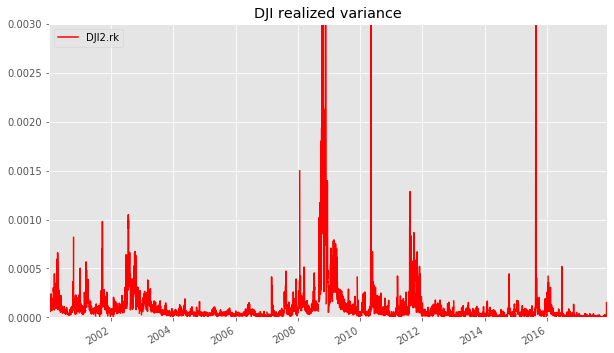

In [53]:
dji = pd.DataFrame(rv1['DJI2.rk'])
dji.plot(color='red', grid=True, title='DJI realized variance',figsize=(10, 6), ylim=(0,0.003));

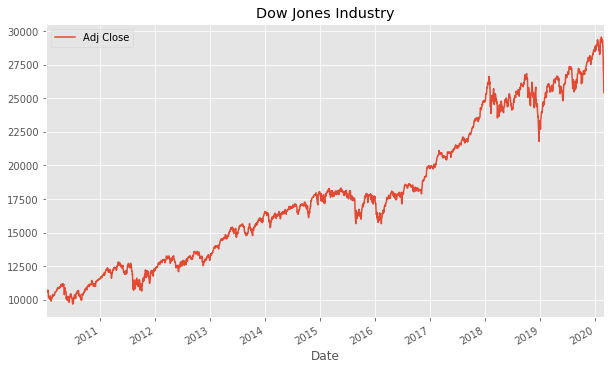

In [54]:
DJI = web.DataReader(name = '^DJI', data_source = 'yahoo', start = '2010-01-01')

DJI = DJI[['Adj Close']]
_ = DJI.plot(title='Dow Jones Industry',figsize=(10,6))

In [55]:
dji['sqrt']= np.sqrt(dji['DJI2.rk']) 
dji['log_sqrt'] = np.log(dji['sqrt'])
def del_Raw(q, x):
    return [np.mean(np.abs(dji['log_sqrt'] - dji['log_sqrt'].shift(lag)) ** q) for lag in x]

[0.07040358721957671, 0.13667508599861078, 0.19859582878317328, 0.25608625651986144, 0.35774754567289585]


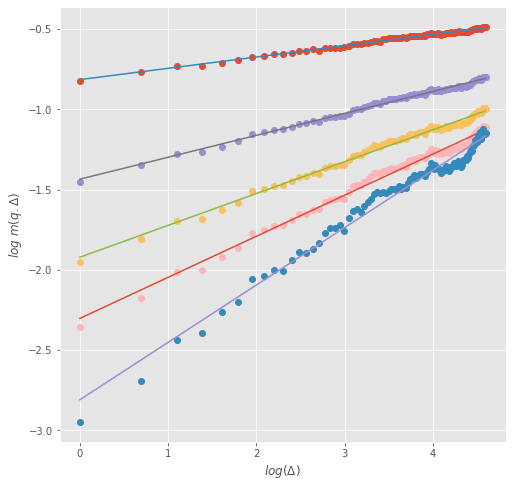

In [56]:
plt.figure(figsize=(8, 8)) 
plt.xlabel('$log(\Delta)$') 
plt.ylabel('$log\ m(q.\Delta)$') 
plt.ylim=(-3, -.5)
zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3]) # m 
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o')
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1) 
    plt.plot(np.log(x), np.log(x) * model[0] + model[1]) 
    zeta_q.append(model[0])
print(zeta_q)

0.1237937501370833


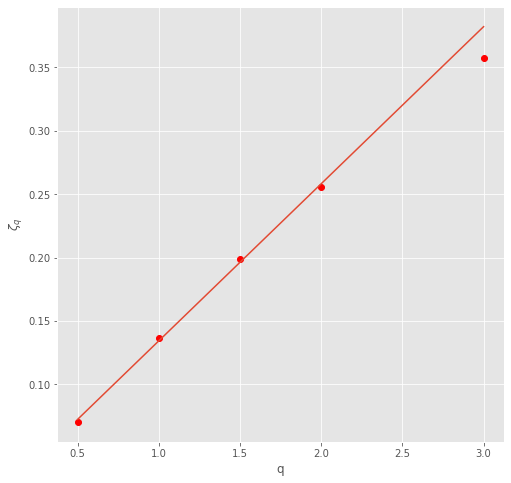

In [57]:
plt.figure(figsize=(8,8)) 
plt.xlabel('q') 
plt.ylabel('$\zeta_{q}$') 
plt.plot(qVec, zeta_q, 'or')
line = np.polyfit(qVec[:4], zeta_q[:4],1) 
plt.plot(qVec, line[0] * qVec + line[1]) 
h_est= line[0]
print(h_est)

We can see that the slope H is a constant, and that can make sure that our model is stable.

Try second order momentum for other realized volatilities

In [58]:
def dlsig2(sic, x, pr=False): 
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x]) 
        a=a ** 2
        print (a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

In [59]:
h = list()
nu = list()  # gamma
for col in rv1.columns: 
    sig = rv1[col]
    sig = np.log(np.sqrt(sig))
    sig = sig.dropna()
    model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1) 
    nu.append(np.sqrt(np.exp(model[1]))) 
    h.append(model[0]/2.)
OxfordH = pd.DataFrame({'names':rv1.columns, 'h_est': h, 'nu_est': nu})

In [60]:
OxfordH

,names,h_est,nu_est
0,SPX2.rk,0.129279,0.324802
1,FTSE2.rk,0.140566,0.267038
2,N2252.rk,0.110684,0.326482
3,GDAXI2.rk,0.145953,0.277026
4,RUT2.rk,NaN,NaN
5,AORD2.rk,0.081706,0.358325
6,DJI2.rk,0.127363,0.318882
7,IXIC2.rk,NaN,NaN
8,FCHI2.rk,0.127367,0.292810
9,HSI2.rk,0.098814,0.281513


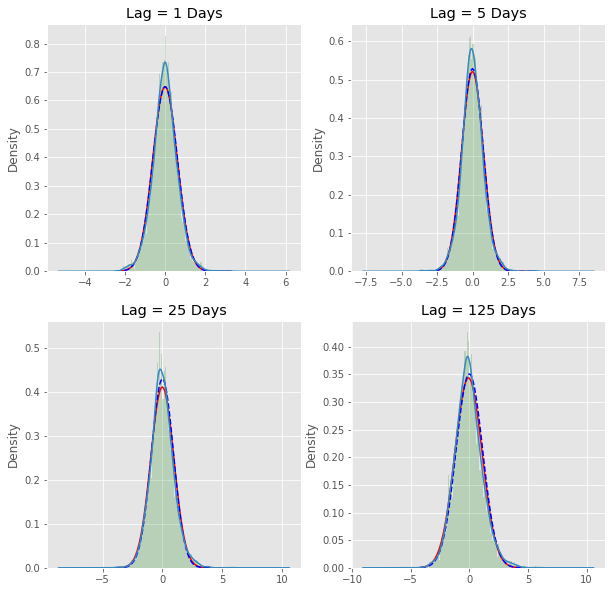

In [61]:
# plot volatility distribution
def plotScaling(j, scaleFactor): 
    col_name = rv1.columns[j]
    v = rv1[col_name]
    x = np.arange(1,101)
    def xDel(x, lag):
        return x-x.shift(lag)
    def sdl(lag):
        return (xDel(np.log(v), lag)).std()
    sd1 = (xDel(np.log(v), 1)).std()
    h = OxfordH['h_est'][j]
    f, ax = plt.subplots(2,2,sharex=False, sharey=False, figsize=(10, 10))
    for i_0 in range(0, 2):
        for i_1 in range(0, 2):
            la = scaleFactor ** (i_1*1+i_0*2)
            hist_val = xDel(np.log(v), la).dropna() 
            std = hist_val.std()
            mean = hist_val.mean()
            ax[i_0][i_1].set_title('Lag = %s Days' %la)
            n, bins, patches = ax[i_0][i_1].hist(hist_val.values, bins=100,normed=1, facecolor='green',alpha=0.2) 
            ax[i_0][i_1].plot(bins, norm.pdf(bins,mean,std), "r")
            ax[i_0][i_1].plot(bins, norm.pdf(bins,0,sd1 * la ** h), "b--") 
            hist_val.plot(kind='density', ax=ax[i_0][i_1])

plotScaling(6,5)

In [62]:
print('Done !')

Done !
